In [53]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, davies_bouldin_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
import nltk
import hdbscan
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

In [54]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
# --- Step 1: Load the dataset ---
file_path = '../data/events.csv'  # Update the path as needed
events = pd.read_csv(file_path)

In [56]:
# --- Step 2: Balance the dataset ---
min_count = events['event_type'].value_counts().min()
balanced_events = events.groupby('event_type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

C:\Users\stoic\AppData\Local\Temp\ipykernel_24084\1533280990.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_events = events.groupby('event_type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [57]:
# --- Step 3: Preprocess the text column ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [58]:
def preprocess_text(text):
    # Lowercase and remove punctuation/numbers
    text = text.lower()
    text = ''.join([char for char in text if char not in punctuation and not char.isdigit()])
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [59]:
balanced_events['processed_text'] = balanced_events['text'].apply(preprocess_text)

In [60]:
# --- Step 4: Convert text to numerical representation using TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Ensure at least 100 features
text_features = tfidf_vectorizer.fit_transform(balanced_events['processed_text'])

In [61]:
# --- Step 5: Perform grid search to tune HDBSCAN parameters ---
param_grid = {
    'min_samples': [5, 10, 20],
    'min_cluster_size': [20, 30, 50],
    'metric': ['euclidean', 'manhattan']
}

best_score = -1
best_model = None
results = []

In [62]:
# Grid search over parameters
for params in tqdm(list(ParameterGrid(param_grid))):
    hdbscan_clusterer = hdbscan.HDBSCAN(
        min_samples=params['min_samples'],
        min_cluster_size=params['min_cluster_size'],
        metric=params['metric']
    )
    hdbscan_clusterer.fit(text_features.toarray())
    
    # Evaluate clustering
    if len(set(hdbscan_clusterer.labels_)) > 1:
        silhouette = silhouette_score(text_features.toarray(), hdbscan_clusterer.labels_)
        results.append((params, silhouette))
        if silhouette > best_score:
            best_score = silhouette
            best_model = hdbscan_clusterer

100%|██████████| 18/18 [00:25<00:00,  1.40s/it]


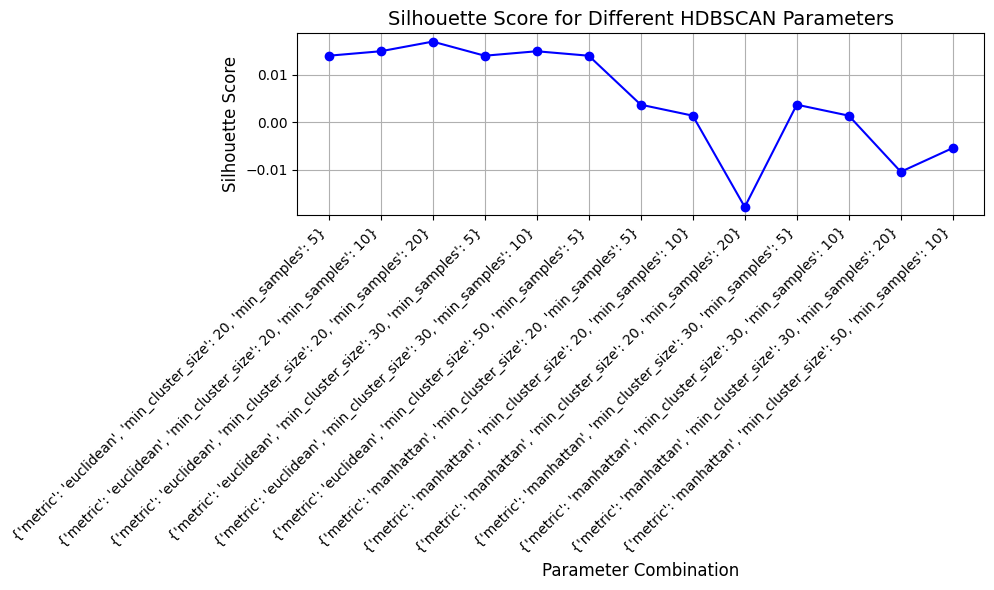

In [63]:
# Plot the variation of silhouette score across parameter values
results_df = pd.DataFrame(results, columns=["Parameters", "Silhouette Score"])
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_df)), results_df["Silhouette Score"], marker='o', color='b')
plt.xticks(range(len(results_df)), results_df["Parameters"], rotation=45, ha='right')
plt.title("Silhouette Score for Different HDBSCAN Parameters", fontsize=14)
plt.xlabel("Parameter Combination", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
# --- Step 6: Use the best model to assign clusters ---
clusters = best_model.fit_predict(text_features.toarray())

In [65]:
# Evaluate clustering
if len(set(clusters)) > 1:
    silhouette = silhouette_score(text_features.toarray(), clusters)
    ari = adjusted_rand_score(balanced_events['event_type'], clusters)
    homogeneity = homogeneity_score(balanced_events['event_type'], clusters)
    dbi = davies_bouldin_score(text_features.toarray(), clusters)
else:
    silhouette = ari = homogeneity = dbi = "Not Applicable"

print("\nClustering Results:")
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Homogeneity Score: {homogeneity}")
print(f"Davies-Bouldin Index: {dbi}")


Clustering Results:
Silhouette Score: 0.01703922126631472
Adjusted Rand Index (ARI): 0.023535850021983586
Homogeneity Score: 0.10830036669489802
Davies-Bouldin Index: 2.5084067331664284


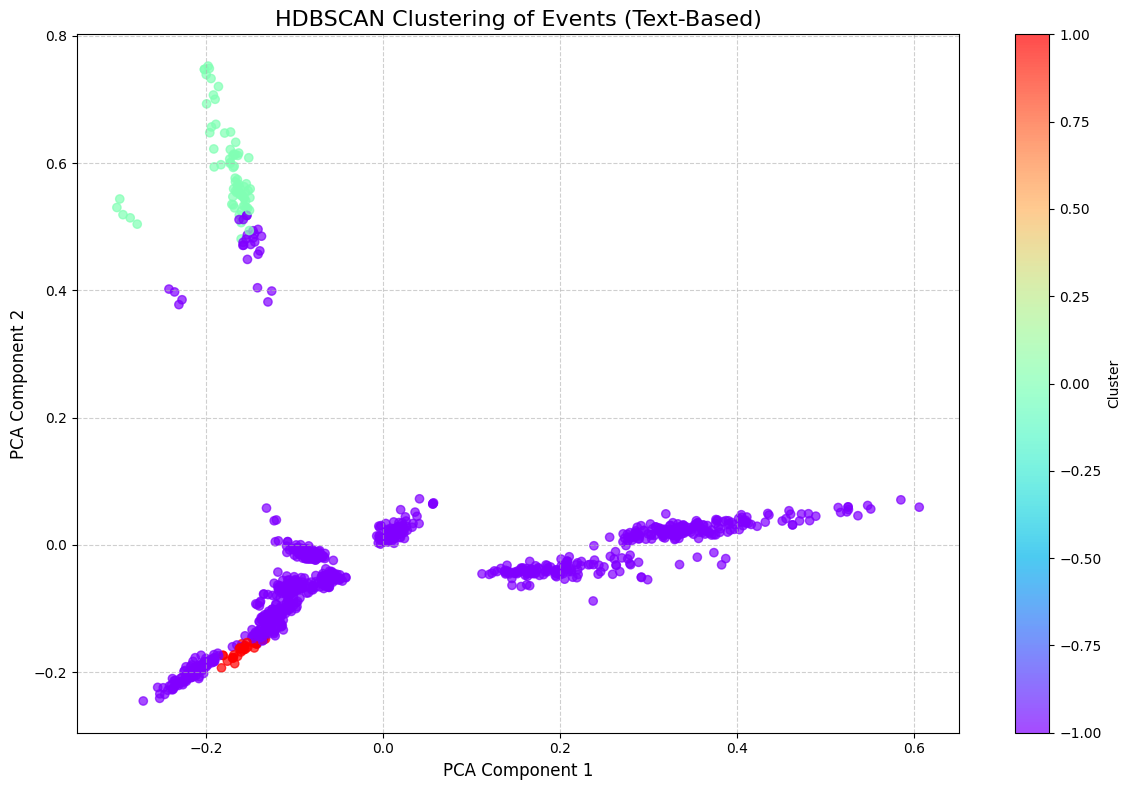

In [66]:
# --- Step 7: Visualize clusters using PCA ---
pca = PCA(n_components=2)
pca_features = pca.fit_transform(text_features.toarray())

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=clusters,
    cmap='rainbow',
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title("HDBSCAN Clustering of Events (Text-Based)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [67]:
# --- Step 8: Interpret clusters ---
cluster_labels = pd.DataFrame({'Event Type': balanced_events['event_type'], 'Cluster': clusters})
cluster_summary = cluster_labels.groupby('Cluster')['Event Type'].value_counts(normalize=True).unstack(fill_value=0)

print("\nCluster Summary (Proportion of Event Types per Cluster):")
print(cluster_summary)


Cluster Summary (Proportion of Event Types per Cluster):
Event Type        1         2         3         4         5         6   \
Cluster                                                                  
-1          0.100301  0.100301  0.100301  0.100301  0.100301  0.100301   
 0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 1          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

Event Type        7         8         9         10        11  
Cluster                                                       
-1          0.100301  0.071214  0.100301  0.100301  0.026078  
 0          0.000000  0.000000  0.000000  0.000000  1.000000  
 1          0.000000  1.000000  0.000000  0.000000  0.000000  


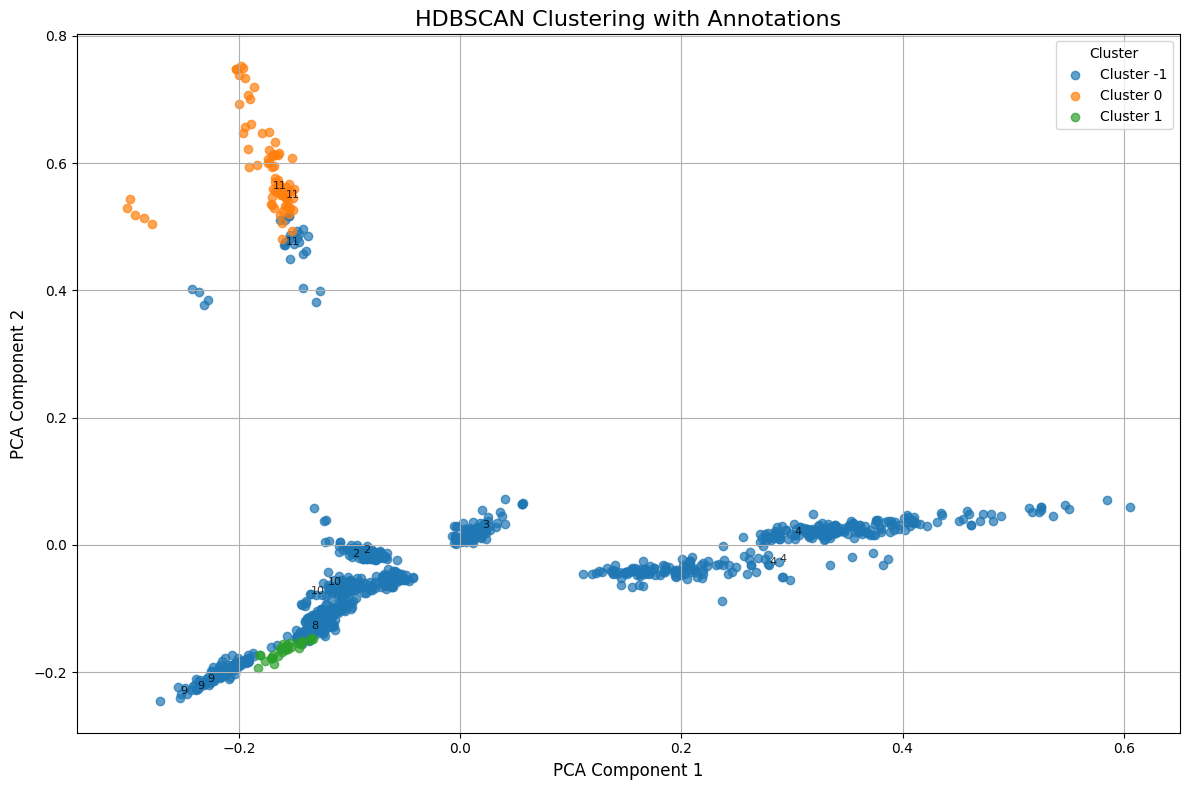

In [68]:
# --- Step 9: Annotated PCA Visualization ---
plt.figure(figsize=(12, 8))
for cluster in np.unique(clusters):
    cluster_points = pca_features[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.7)

sample_indices = np.random.choice(range(len(pca_features)), size=15, replace=False)
for idx in sample_indices:
    plt.annotate(
        balanced_events.iloc[idx]['event_type'],
        (pca_features[idx, 0], pca_features[idx, 1]),
        fontsize=8,
        alpha=0.8
    )

plt.title("HDBSCAN Clustering with Annotations", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()